In this notebook, you will find our experimental results for the project in M2 IASD course : Anonymisation.

Our results are based on the work proposed by Goodfellow and al : Deep Learning with Differential Privacy (https://arxiv.org/abs/1607.00133)

In the first part, you will find the useful modules and functions necessary to run the algorithms. In the next part we will see the results on MNIST and then on Fashion MNIST

# Utilities

In [ ]:
!pip install tensorflow_privacy

     |████████████████████████████████| 153kB 6.0MB/s 


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdagradGaussianOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamGaussianOptimizer

TensorFlow 1.x selected.


In [ ]:
def plot_acc(acc,NM,LR,L2):
  '''plot accuracy depending on epoch for different value of NM noise multiplier, LR : Learning rate and L2 : L2 norm clipping
  Input :
  - acc : (p,q,r,n)-array containing accuracy calculated with function evaluation_Acc
  - NM : array of dimension (p,1) with the values of noise multiplier used for evaluate acc
  - LR : array of dimension (q,1) with the values of Learning Rate used for evaluate acc
  - L2 : array of dimension (r,1) with the values of L2 norm clipping used for evaluate acc
  '''
  p,q,r,n=np.shape(acc)
  epochs = range(1, n + 1)
  plt.figure(figsize=(10,7))
  if p==1:
    if q==1:
      for k in range(r):
        plt.plot(epochs, acc[0,0,k,:], 'x--', label='L2 clip={}'.format(L2[k]))
    elif r==1:
      for j in range(q):
        plt.plot(epochs, acc[0,j,0,:], 'x--', label='LR={}'.format(LR[j]))
    else:
      for j in range(q):
        for k in range(r):
          plt.plot(epochs, acc[0,j,k,:], 'x--', label='LR={},L2 clip={}'.format(LR[j],L2[k]))
        
  elif q==1:
    if r==1:
      for i in range(p):
        plt.plot(epochs, acc[i,0,0,:], 'x--', label='NM={}'.format(NM[i]))
    else:
      for i in range(p):
        for k in range(r):
          plt.plot(epochs, acc[i,0,k,:], 'x--', label='NM={},L2 clip={}'.format(NM[i],L2[k]))
  elif r==1:
    for i in range(p):
      for j in range(q):
        plt.plot(epochs, acc[i,j,0,:], 'x--', label='NM={},LR={}'.format(NM[i],LR[j]))
        
  else:
     for i in range (p):
      for j in range(q):
        for k in range(r):
          plt.plot(epochs, acc[i,j,k,:], 'x--', label='NM ={}, LR={},L2 clip={}'.format(NM[i],LR[j],L2[k]))
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()  

def evaluation_Acc(loss,NM,num_microbatches,LR,L2clip,epochs):
  n=epochs
  p=len(NM)
  q=len(LR)
  r=len(L2clip)
  batch_size=250
  acc=np.zeros((p,q,r,n))

  for i in range(len(NM)):
    
    for k in range(q):
      for j in range(r):
        model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='same',
                           activation='relu',
                           input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(2, 1),
        tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
        tf.keras.layers.MaxPool2D(2, 1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')])
        optimizer = DPGradientDescentGaussianOptimizer(
          l2_norm_clip=l2_norm_clip,
          noise_multiplier=NM[i],
          num_microbatches=num_microbatches,
          learning_rate=LR[k])
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
      
      
    
        history=model.fit(train_data, train_labels,epochs=epochs,
          validation_data=(test_data, test_labels),
          batch_size=batch_size,verbose=False)
  
        acc[i,k,j,:]=history.history['acc']
  return acc
    
def calcul_epsilon(N, batch_size, NM, Epochs, delta):
  ''' return an array of size (nxm) with value of epsilon for a given array of noise multiplier NM array (nx1) and an array of epochs (mx1)'''
  n=len(NM)
  m=len(Epochs)
  eps=np.zeros((n,m))
  for i in range(n):
    for j in range (m):
      e,_=compute_dp_sgd_privacy.compute_dp_sgd_privacy(N, batch_size, NM[i], Epochs[j], delta)
      eps[i,j]=e
  return eps

def evaluation_Acc_Adagrad(loss,NM,num_microbatches,LR,L2clip,epochs):
  n=epochs
  p=len(NM)
  q=len(LR)
  r=len(L2clip)
  batch_size=250
  acc=np.zeros((p,q,r,n))

  for i in range(len(NM)):
    
    for k in range(q):
      for j in range(r):
        model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='same',
                           activation='relu',
                           input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(2, 1),
        tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
        tf.keras.layers.MaxPool2D(2, 1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')])
        optimizer = DPAdagradGaussianOptimizer(
          l2_norm_clip=l2_norm_clip,
          noise_multiplier=NM[i],
          num_microbatches=num_microbatches,
          learning_rate=LR[k])
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
      
      
    
        history=model.fit(train_data, train_labels,epochs=epochs,
          validation_data=(test_data, test_labels),
          batch_size=batch_size,verbose=False)
  
        acc[i,k,j,:]=history.history['acc']
  return acc

def evaluation_Acc_Adam(loss,NM,num_microbatches,LR,L2clip,epochs):
  n=epochs
  p=len(NM)
  q=len(LR)
  r=len(L2clip)
  batch_size=250
  acc=np.zeros((p,q,r,n))

  for i in range(len(NM)):
    
    for k in range(q):
      for j in range(r):
        model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='same',
                           activation='relu',
                           input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(2, 1),
        tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
        tf.keras.layers.MaxPool2D(2, 1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')])
        optimizer = DPAdamGaussianOptimizer(
          l2_norm_clip=l2_norm_clip,
          noise_multiplier=NM[i],
          num_microbatches=num_microbatches,
          learning_rate=LR[k])
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
      
      
    
        history=model.fit(train_data, train_labels,epochs=epochs,
          validation_data=(test_data, test_labels),
          batch_size=batch_size,verbose=False)
  
        acc[i,k,j,:]=history.history['acc']
  return acc

# MNIST

MNIST is a famous dataset containing 70 000 images of hand-written numbers from 0 to 9 : the goal is to classify each image to its corresponding number 


## Load Dataset


In [ ]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='same',
                           activation='relu',
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Hyperparameters

In [ ]:
epochs = 15
batch_size = 250
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 250
learning_rate = 0.25
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)


## Experimental Results

### Influence of L2 clipping

0.5
0.1
0.1
0.1
0.1


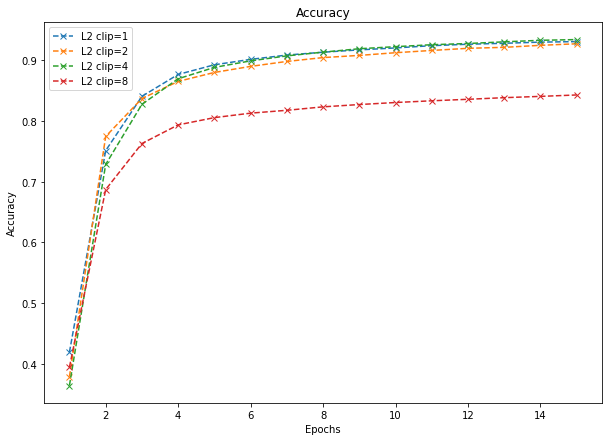

In [ ]:
NM=[0.5]
LR=[0.1]
L2=[1,2,4,8]
acc=evaluation_Acc(loss,NM,250,LR,L2,epochs)
plot_acc(acc,NM,LR,L2)

### Influence of Noise Multiplier

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


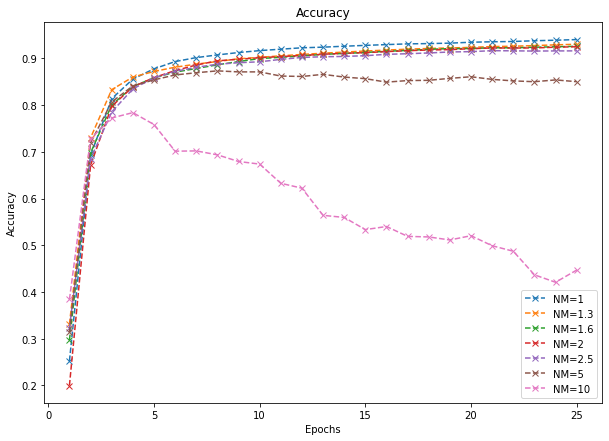

In [ ]:
NM=[1,1.3,1.6,2,2.5,5,10]
LR=[0.08]     
epochs=25
L2=[4]
accNM=evaluation_Acc(loss,NM,250,LR,L2,epochs)
plot_acc(accNM,NM,LR,L2)  

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 3600 steps satisfies differential privacy with eps = 1.91 and delta = 1e-05.
The optimal RDP order is 10.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 1.3 iterated over 3600 steps satisfies differential privacy with eps = 1.18 and delta = 1e-05.
The optimal RDP order is 17.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 1.6 iterated over 3600 steps satisfies differential privacy with eps = 0.872 and delta = 1e-05.
The optimal RDP order is 26.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 2 iterated over 3600 steps satisfies differential privacy with eps = 0.663 and delta = 1e-05.
The optimal RDP order is 35.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 2.5 iterated over 3600 steps satisfies differential privacy with eps = 0.514 and delta = 1e-05.
The optimal RDP order is 45.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 5 iterated over 3600 st

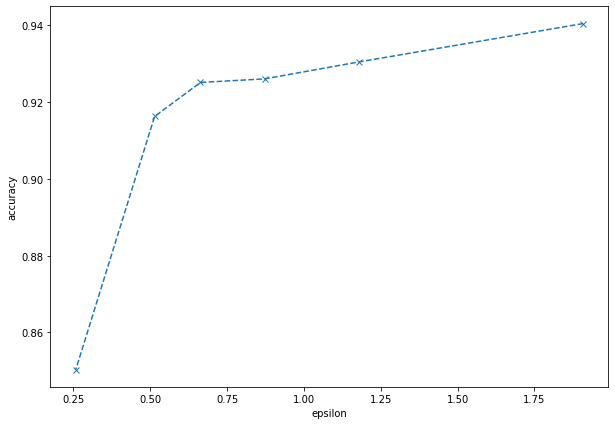

In [ ]:
epsNM=calcul_epsilon(60000,250, NM, [15], 1e-5)
plt.figure(figsize=(10,7))
plt.plot(epsNM[:-1],accNM[:-1,0,0,-1],'x--')
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.show()

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 240 steps satisfies differential privacy with eps = 1.32 and delta = 1e-05.
The optimal RDP order is 10.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 480 steps satisfies differential privacy with eps = 1.36 and delta = 1e-05.
The optimal RDP order is 10.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 720 steps satisfies differential privacy with eps = 1.41 and delta = 1e-05.
The optimal RDP order is 10.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 960 steps satisfies differential privacy with eps = 1.45 and delta = 1e-05.
The optimal RDP order is 10.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 1200 steps satisfies differential privacy with eps = 1.49 and delta = 1e-05.
The optimal RDP order is 10.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 1440 steps satisfies

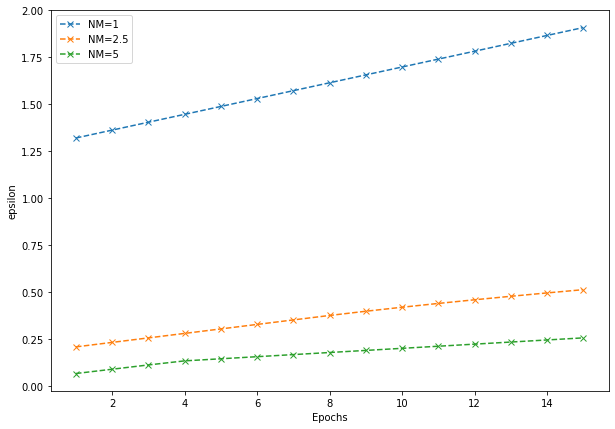

In [ ]:
Epochs=np.arange(1,16)
NM=[1,2.5,5]
epsNM2=calcul_epsilon(60000,250, NM, Epochs, 1e-5)
n=np.shape(epsNM2)[0]
plt.figure(figsize=(10,7))
for i in range(n):
  plt.plot(Epochs,epsNM2[i,:],'x--',label='NM={}'.format(NM[i]))
plt.xlabel('Epochs')
plt.ylabel('epsilon')
plt.legend()
plt.show()

### Use of another optimizer

In [ ]:
NM=[0.5]
LR=[0.1]
L2=[4]
epochs=15
accSGD=evaluation_Acc(loss,NM,250,LR,L2,epochs)
accAdam=evaluation_Acc_Adam(loss,NM,250,[0.001],L2,epochs)
accAdagrad=evaluation_Acc_Adagrad(loss,NM,250,LR,L2,epochs)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


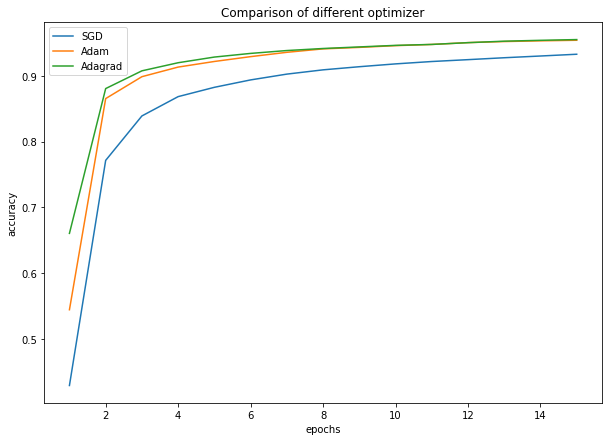

In [ ]:
plt.figure(figsize=(10,7))
epochs = range(1, 15 + 1)
plt.plot(epochs,accSGD[0,0,0,:],label='SGD')
plt.plot(epochs,accAdam[0,0,0,:],label='Adam')
plt.plot(epochs,accAdagrad[0,0,0,:],label='Adagrad')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Comparison of different optimizer')
plt.legend()
plt.show()


# Fashion MNIST

## Load Dataset

In [ ]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

4423680/4422102 [==============================] - 0s 0us/step


## Hyperparameters

In [ ]:
epochs = 10
batch_size = 250
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 250
learning_rate = 0.05
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)


## Experimental Results

### Influence of L2 clipping

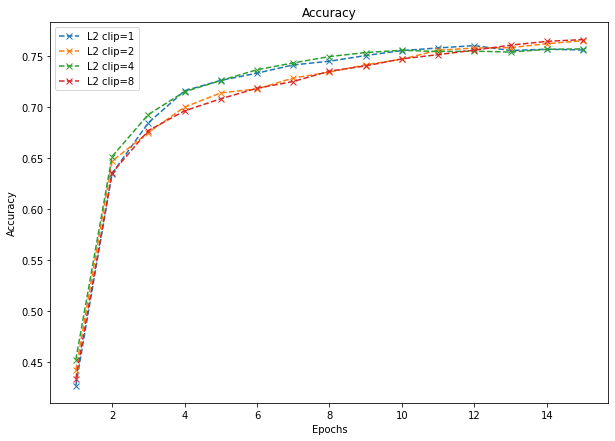

In [ ]:
NM=[2]
LR=[0.2]
L2=[1,2,4,8]
acc=evaluation_Acc(loss,NM,250,LR,L2,15)
plot_acc(acc,NM,LR,L2)

### Different optimizers

In [ ]:
NM=[1]
LR=[0.2]
L2=[4]
epochs=15
accSGD=evaluation_Acc(loss,NM,250,LR,L2,epochs)
accAdam=evaluation_Acc_Adam(loss,NM,250,[0.005],L2,epochs)
accAdagrad=evaluation_Acc_Adagrad(loss,NM,250,LR,L2,epochs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


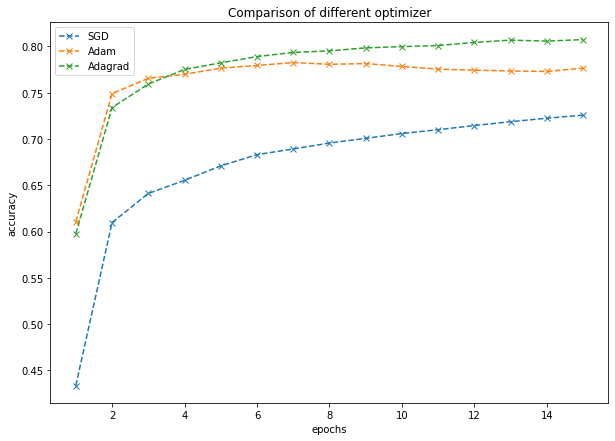

In [ ]:
plt.figure(figsize=(10,7))
epochs = range(1, 15 + 1)
plt.plot(epochs,accSGD[0,0,0,:],'x--',label='SGD')
plt.plot(epochs,accAdam[0,0,0,:],'x--',label='Adam')
plt.plot(epochs,accAdagrad[0,0,0,:],'x--',label='Adagrad')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Comparison of different optimizer')
plt.legend()
plt.show()


### influence of Noise multiplier

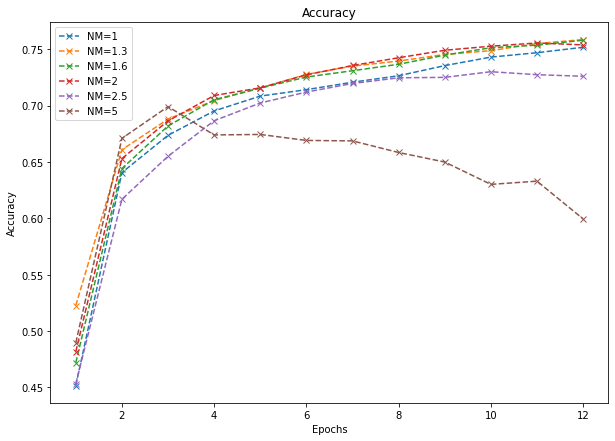

In [ ]:
NM=[1,1.3,1.6,2,2.5,5]
LR2=[0.2] 
L2=[4]
accNM=evaluation_Acc(loss,NM,250,LR2,L2,12)
plot_acc(accNM,NM,LR2,L2)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 2880 steps satisfies differential privacy with eps = 1.78 and delta = 1e-05.
The optimal RDP order is 10.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 1.3 iterated over 2880 steps satisfies differential privacy with eps = 1.09 and delta = 1e-05.
The optimal RDP order is 17.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 1.6 iterated over 2880 steps satisfies differential privacy with eps = 0.788 and delta = 1e-05.
The optimal RDP order is 27.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 2 iterated over 2880 steps satisfies differential privacy with eps = 0.594 and delta = 1e-05.
The optimal RDP order is 39.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 2.5 iterated over 2880 steps satisfies differential privacy with eps = 0.46 and delta = 1e-05.
The optimal RDP order is 51.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 5 iterated over 2880 ste

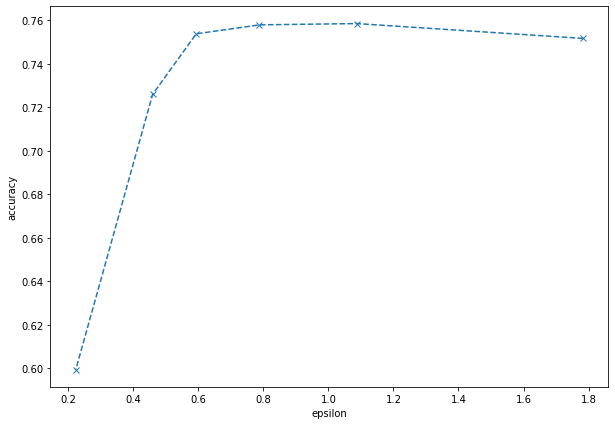

In [ ]:
epsNM=calcul_epsilon(60000,250, NM, [12], 1e-5)
plt.figure(figsize=(10,7))
plt.plot(epsNM,accNM[:,0,0,-1],'x--')
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.show()